In [1]:
#source & inspired 
#from https://www.kaggle.com/code/hugosjoberg/house-prices-prediction-using-keras
#above web is heavily refer in evaluation
#from https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf/notebook
#
#
#-----------------------------------------
#Import & Select Data Process
import csv
import pandas as pd
#import file for evaluation process
#require matplotlib,tensorflow,sklearn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import arange
import seaborn as sns

In [2]:
#import data
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#drop ID
df = data.drop("Id", axis=1)
print(df.isna().sum())

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64


In [3]:
#find the mean of the price
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

c:\Users\Acer\anaconda3\envs\Nlp\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Acer\anaconda3\envs\Nlp\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


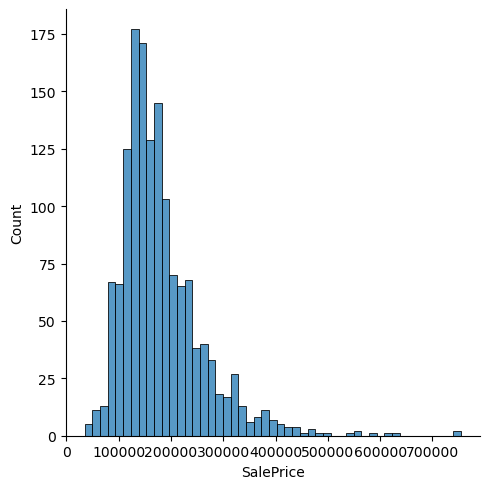

In [4]:
#make a picture(visualize) out of it
sns.displot(df["SalePrice"])

In [5]:
#select only integer and float variable
df_num = df.select_dtypes(include=["float64","int64"])
df_num.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


<Axes: >

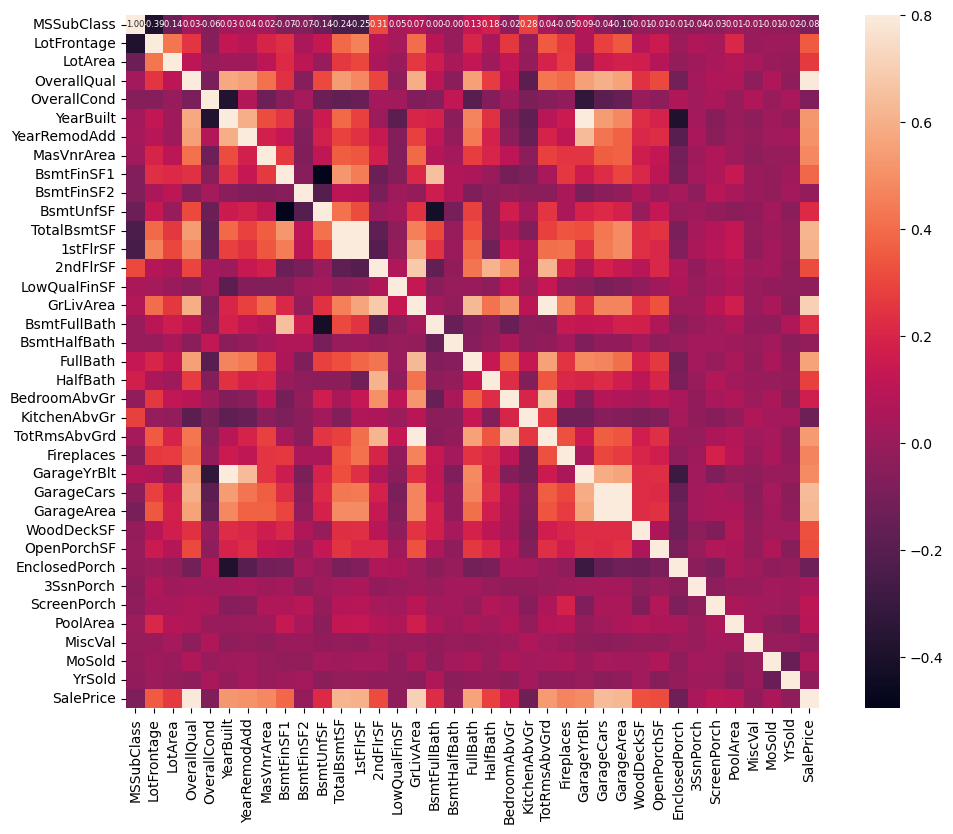

In [6]:
#try to find the important-related column to the price through heat map
corrmat = df_num.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8,annot=True, square=True,fmt='.2f',annot_kws={'size': 6})

In [7]:
#select a data for the new dataframe by using above heatmap as reference point
#will pick something above 0.5 - 0.6 and totalbsmtsf2 and 1stflrsf
df_train = data[["OverallQual","GrLivArea","GarageCars","FullBath","TotalBsmtSF","YearBuilt","SalePrice"]]
df_test = test_data[["OverallQual","GrLivArea","GarageCars","FullBath","TotalBsmtSF","YearBuilt"]]


In [8]:
#Check for NaN
#somehow the picked column is not filled with NaN or some missing value?
df_train.isna().sum()

OverallQual    0
GrLivArea      0
GarageCars     0
FullBath       0
TotalBsmtSF    0
YearBuilt      0
SalePrice      0
dtype: int64

In [9]:
df_test.isna().sum()

OverallQual    0
GrLivArea      0
GarageCars     1
FullBath       0
TotalBsmtSF    1
YearBuilt      0
dtype: int64

In [10]:
#find mean in garage car and TotalbsmtSF
print("mean of Garage Car :", df_test["GarageCars"].mean().sum())
print("mean of the total square feet of basement area(totalbsmtsf) :", df_test["TotalBsmtSF"].mean().sum())

mean of Garage Car : 1.7661179698216736
mean of the total square feet of basement area(totalbsmtsf) : 1046.1179698216736


In [11]:
#Fill the void in the test data #cleaning process
#Fill GarageCars
for z in df_test.index:
 raw = str(df_test.loc[z, "GarageCars"])
 if (("?" or "NaN" or " ") in raw) == True:
  df_test.loc[z, "GarageCars"] = 1.76
#Fill TotalBsmtSF
for a in df_test.index:
 raw = str(df_test.loc[a, "TotalBsmtSF"])
 if (("?" or "NaN" or " ") in raw) == True:
  df_test.loc[a, "TotalBsmtSF"] = 1046.0

In [12]:
df_test.isna().sum()
#bruh

OverallQual    0
GrLivArea      0
GarageCars     1
FullBath       0
TotalBsmtSF    1
YearBuilt      0
dtype: int64

In [13]:
#check last time before go to train process for train
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
OverallQual,0,0.0
GrLivArea,0,0.0
GarageCars,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
YearBuilt,0,0.0
SalePrice,0,0.0


In [14]:
#check last time before go to train process for test 
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#note idk why above got one missing NaN why this not exist
#maybe it's about a 0 anda null variable?

,Total,Percent
OverallQual,0,0.0
GrLivArea,0,0.0
GarageCars,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
YearBuilt,0,0.0
SalePrice,0,0.0


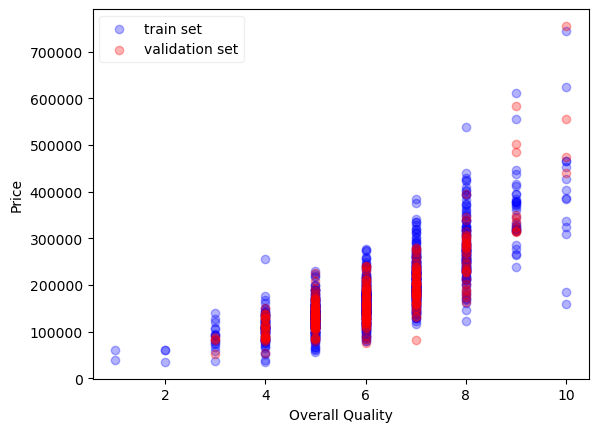

In [15]:
# Split dataset into train and validation(visualize):
def split_dataset(df_train, train_frac=0.7):
 train = df_train.sample(frac=train_frac)
 val = df_train.drop(train.index)
 return train, val

#
train_1, validation_1 = split_dataset(df_train, train_frac=0.8)
plt.scatter(train_1['OverallQual'].astype(int), train_1['SalePrice'].astype(int), c='blue', alpha=0.3)
plt.scatter(validation_1['OverallQual'].astype(int), validation_1['SalePrice'].astype(int), c='red', alpha=0.3)
plt.xlabel('Overall Quality')
plt.ylabel('Price')
plt.legend(['train set', 'validation set'], framealpha=0.3)
plt.show()

In [16]:
# Create model:
model = Sequential()
model.add(Input(shape=(5,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='relu'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 41,601
Trainable params: 41,601
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
#set data for train
scale = StandardScaler()
X_train = df_train[["OverallQual","GrLivArea","GarageCars","FullBath","YearBuilt"]]
y = df_train[["SalePrice"]]
#------------------------------------
#use stardard Scaler 
#Standardize features by removing the mean and scaling to unit variance.
#The standard score of a sample x is calculated as:
#z = (x - u) / s 
#Result = (training data - training sample) / standard deviation
#this part try some fit by use scaler
X_train = scale.fit_transform(X_train)
y = df_train["SalePrice"].values
seed = 7
np.random.seed(seed)
#split into 67% for train and 33% for test
#The train_test_split part is a tool that will pick the data and randomize it 
#it come from the sklearn.model_selection
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y, test_size=0.33,random_state = seed)
#---------------

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

# Assuming you have your model defined like this
model = Sequential([
    Dense(200, input_dim=X_train.shape[1], activation='relu'),  # Assuming X_train is your input data
    Dense(200, activation='relu'),
    Dense(1, activation='linear')  # Use 'linear' activation for regression
])

# Change the first layer to use InputLayer
model.layers[0] = InputLayer(input_shape=(X_train.shape[1],))

# Rest of your code remains the same
loss = 'mse'
metric = 'mae'
epochs = 3000
model.compile(loss=loss, optimizer='adam', metrics=[metric])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=128, verbose=1, validation_data=(X_test, Y_test))




Epoch 1/3000


8/8 [==============================] - 1s 27ms/step - loss: 38028652544.0000 - mae: 179315.3125 - val_loss: 41088901120.0000 - val_mae: 184177.1094
Epoch 2/3000
8/8 [==============================] - 0s 7ms/step - loss: 38028083200.0000 - mae: 179313.7969 - val_loss: 41088176128.0000 - val_mae: 184175.2656
Epoch 3/3000
8/8 [==============================] - 0s 6ms/step - loss: 38027251712.0000 - mae: 179311.5938 - val_loss: 41087012864.0000 - val_mae: 184172.4219
Epoch 4/3000
8/8 [==============================] - 0s 8ms/step - loss: 38025904128.0000 - mae: 179308.0938 - val_loss: 41085210624.0000 - val_mae: 184168.0312
Epoch 5/3000
8/8 [==============================] - 0s 6ms/step - loss: 38023860224.0000 - mae: 179302.9062 - val_loss: 41082499072.0000 - val_mae: 184161.5312
Epoch 6/3000
8/8 [==============================] - 0s 6ms/step - loss: 38020870144.0000 - mae: 179295.3125 - val_loss: 41078566912.0000 - val_mae: 184152.2500
Epoch 7/3000
8/8 [=================

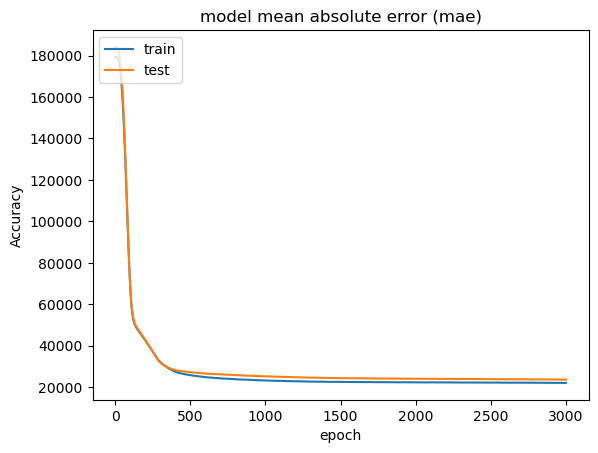

In [19]:

# Display metric:
#bruh pure relu is kinda good... maybe the number is too vast
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mean absolute error (mae)')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [20]:
#note the data have quite a wide range (the said range around 20000 dollars)
#some explanation in the https://www.kaggle.com/code/hugosjoberg/house-prices-prediction-using-keras
#yeah maybe the model is kinda meh too so good luck!
#try to count id thingy & prediction set
something_data = pd.read_csv("test.csv")
cols = ["OverallQual","GrLivArea","GarageCars","FullBath","YearBuilt"]
id_col = something_data["Id"].values.tolist()
#This mathematical function helps user to calculate natural logarithmic value of x+1 where x belongs to all the input array elements.
# something_data["GrLivArea"] = np.log1p(something_data["GrLivArea"])
something_data = pd.get_dummies(something_data)
something_data = something_data.fillna(something_data.mean())
X_test = something_data[cols].values
X_test = scale.fit_transform(X_test)

In [21]:

predictions = model.predict(X_test)
print(predictions)

46/46 [==============================] - 0s 1ms/step
[[121965.21]
 [143297.27]
 [167083.42]
 ...
 [141958.19]
 [128719.8 ]
 [258603.62]]


In [22]:
#print a csv file to contain result
result = pd.DataFrame()
result["Id"] = id_col
result["SalePrice"] = predictions

In [23]:
result.to_csv("result.csv", index=False)


In [24]:
import pickle

# Save the model
model.save('house_price_model.h5')


c:\Users\Acer\anaconda3\envs\Nlp\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Save the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scale, scaler_file)
